# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, avg, count, sum, min, max, desc, asc, col, variance, when, lit
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier, GBTClassifier
import numpy as np
import pandas as pd
import datetime
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName('mini project') \
        .getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.count()

286500

In [6]:
df.describe(['sessionId', 'userId']).show()

+-------+-----------------+-----------------+
|summary|        sessionId|           userId|
+-------+-----------------+-----------------+
|  count|           286500|           286500|
|   mean|1041.526554973822|59682.02278593872|
| stddev|726.7762634630741|109091.9499991047|
|    min|                1|                 |
|    max|             2474|               99|
+-------+-----------------+-----------------+



In [7]:
for column in df.columns:
    print('The {} column has {} blank records.'.format(column, df.filter((df[column]=='') | (df[column]==np.nan)).count()))

The artist column has 0 blank records.
The auth column has 0 blank records.
The firstName column has 0 blank records.
The gender column has 0 blank records.
The itemInSession column has 0 blank records.
The lastName column has 0 blank records.
The length column has 0 blank records.
The level column has 0 blank records.
The location column has 0 blank records.
The method column has 0 blank records.
The page column has 0 blank records.
The registration column has 0 blank records.
The sessionId column has 0 blank records.
The song column has 0 blank records.
The status column has 0 blank records.
The ts column has 0 blank records.
The userAgent column has 0 blank records.
The userId column has 8346 blank records.


观察发现有userId为空的无效数据，这些数据产生在用户未登陆的状态，与后面预测用户流失或留存的需求无关，故可以删去

In [4]:
df = df.filter(df.userId != '')

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

##### gender

In [9]:
df.select('userId', 'gender').dropDuplicates().groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



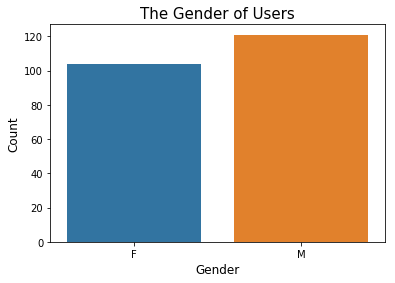

In [10]:
gender_pd = df.select('userId', 'gender').dropDuplicates().groupBy('gender').count().toPandas()
sns.barplot(x='gender', y='count', data=gender_pd)
plt.title("The Gender of Users", fontsize=15)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Count", fontsize=12);

##### level

In [11]:
df.select('userId', 'level').dropDuplicates().groupBy('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|  195|
| paid|  165|
+-----+-----+



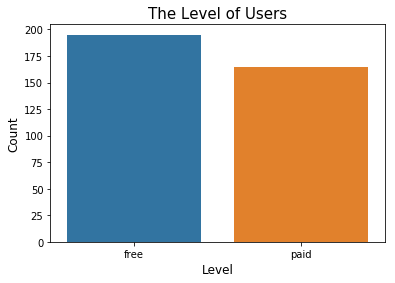

In [12]:
level_pd = df.select('userId', 'level').dropDuplicates().groupBy('level').count().toPandas()
sns.barplot(x='level', y='count', data=level_pd)
plt.title("The Level of Users", fontsize=15)
plt.xlabel("Level", fontsize=12)
plt.ylabel("Count", fontsize=12);

有些用户拥有2个level

##### page

In [13]:
df.groupBy('page').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



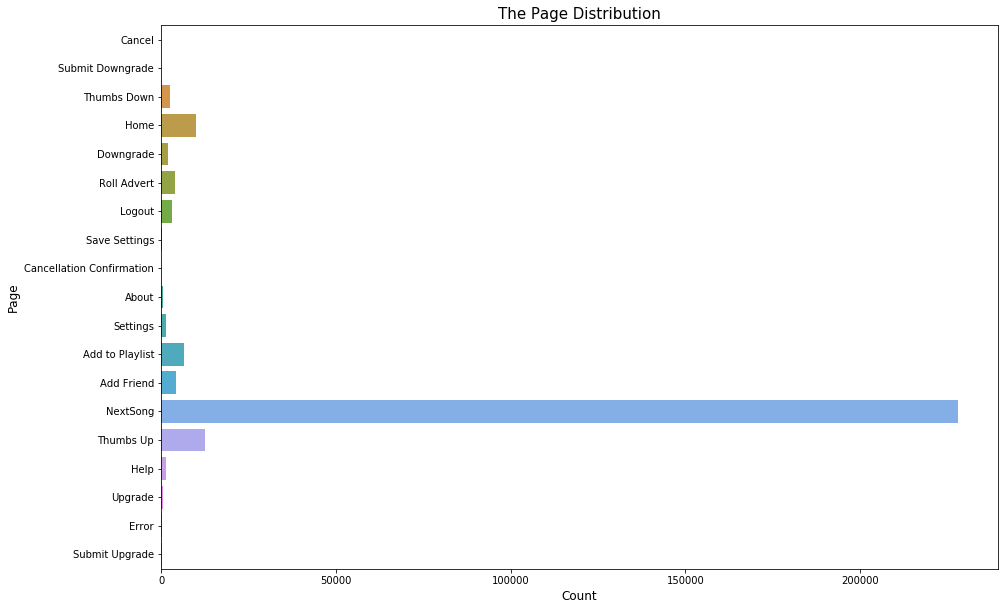

In [14]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
page_pd = df.groupBy('page').count().toPandas()
sns.barplot(x='count', y='page', data=page_pd, ax=ax)
plt.title("The Page Distribution", fontsize=15)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Page", fontsize=12);

##### artist

In [15]:
df.select('artist').groupBy('artist').count().orderBy(desc('count')).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|50046|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows



##### Location

In [16]:
location_state = udf(lambda x: x.split(',')[-1].strip())
df = df.withColumn('locationState', location_state(df.location))

In [17]:
df.select('userId', 'locationState').dropDuplicates().groupBy('locationState').count().orderBy(desc('count')).collect()

[Row(locationState='CA', count=33),
 Row(locationState='TX', count=16),
 Row(locationState='NY-NJ-PA', count=15),
 Row(locationState='FL', count=14),
 Row(locationState='AZ', count=7),
 Row(locationState='CT', count=7),
 Row(locationState='NC', count=6),
 Row(locationState='IL-IN-WI', count=6),
 Row(locationState='MO-IL', count=6),
 Row(locationState='NC-SC', count=6),
 Row(locationState='MI', count=5),
 Row(locationState='NY', count=5),
 Row(locationState='PA-NJ-DE-MD', count=5),
 Row(locationState='MA-NH', count=5),
 Row(locationState='WA', count=4),
 Row(locationState='AL', count=4),
 Row(locationState='DC-VA-MD-WV', count=4),
 Row(locationState='GA', count=4),
 Row(locationState='CO', count=4),
 Row(locationState='MN-WI', count=3),
 Row(locationState='KY', count=3),
 Row(locationState='NV', count=3),
 Row(locationState='IL', count=3),
 Row(locationState='MS', count=3),
 Row(locationState='IN', count=3),
 Row(locationState='OH', count=3),
 Row(locationState='PA', count=3),
 Row(loca

##### Define churned user

In [5]:
churn_lst = []
churn_user = df.select('userId').filter(df.page=="Cancellation Confirmation").collect()
for i in range(len(churn_user)):
    churn_lst.append(churn_user[i][0])
churn = udf(lambda x: 1 if x in churn_lst else 0, IntegerType())
df = df.withColumn('Churn', churn(df.userId))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0)

In [6]:
df.select('userId', 'Churn').dropDuplicates().groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



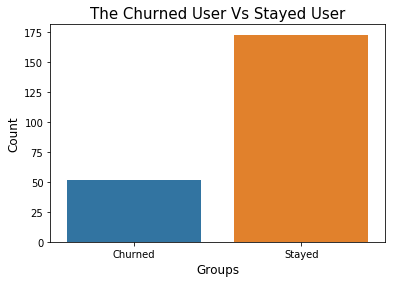

In [7]:
churn_pd = df.select('userId', 'Churn').dropDuplicates().groupBy('Churn').count().toPandas()
churn_pd.Churn = churn_pd.Churn.apply(lambda x: "Churned" if x==1 else "Stayed")
sns.barplot(x="Churn", y="count", data=churn_pd)
plt.title("The Churned User Vs Stayed User", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Count", fontsize=12);

In [8]:
churn_number = churn_pd.loc[churn_pd.Churn=="Churned", "count"][0]
stay_number = churn_pd.loc[churn_pd.Churn=="Stayed", "count"][1]
total_user_number = churn_number + stay_number
print(churn_number, stay_number, total_user_number)

52 173 225


###### Activity of userId 30 (Stayed user)

In [22]:
df.select('userId', 'firstname', 'page', 'song', 'level', 'Churn').where(df.userId=='30').collect()

[Row(userId='30', firstname='Colin', page='NextSong', song='Rockpools', level='paid', Churn=0),
 Row(userId='30', firstname='Colin', page='NextSong', song='Time For Miracles', level='paid', Churn=0),
 Row(userId='30', firstname='Colin', page='NextSong', song='Harder Better Faster Stronger', level='paid', Churn=0),
 Row(userId='30', firstname='Colin', page='NextSong', song='Passengers (Old Album Version)', level='paid', Churn=0),
 Row(userId='30', firstname='Colin', page='Add to Playlist', song=None, level='paid', Churn=0),
 Row(userId='30', firstname='Colin', page='NextSong', song='Fuck Kitty', level='paid', Churn=0),
 Row(userId='30', firstname='Colin', page='NextSong', song='Jade', level='paid', Churn=0),
 Row(userId='30', firstname='Colin', page='NextSong', song='So-Called Friends', level='paid', Churn=0),
 Row(userId='30', firstname='Colin', page='NextSong', song='Represent', level='paid', Churn=0),
 Row(userId='30', firstname='Colin', page='NextSong', song='Here I Am', level='paid

###### Activity of userId 18 (Churned user)

In [23]:
df.select('userId', 'firstname', 'page', 'song', 'level', 'Churn').where(df.userId=='18').collect()

[Row(userId='18', firstname='Adriel', page='Home', song=None, level='paid', Churn=1),
 Row(userId='18', firstname='Adriel', page='NextSong', song='A Beggar On A Beach Of Gold', level='paid', Churn=1),
 Row(userId='18', firstname='Adriel', page='NextSong', song='...slowdance On The Inside (Album Version)', level='paid', Churn=1),
 Row(userId='18', firstname='Adriel', page='NextSong', song='St. Apollonia', level='paid', Churn=1),
 Row(userId='18', firstname='Adriel', page='NextSong', song='Drunk Stripper', level='paid', Churn=1),
 Row(userId='18', firstname='Adriel', page='NextSong', song='In League With Satan', level='paid', Churn=1),
 Row(userId='18', firstname='Adriel', page='Settings', song=None, level='paid', Churn=1),
 Row(userId='18', firstname='Adriel', page='NextSong', song='The Quest', level='paid', Churn=1),
 Row(userId='18', firstname='Adriel', page='NextSong', song='Waking The Demon', level='paid', Churn=1),
 Row(userId='18', firstname='Adriel', page='NextSong', song='Why Do

##### Define downgrade user

In [9]:
down_lst = []
down_user = df.select('userId').filter(df.page=="Downgrade").collect()
for i in range(len(down_user)):
    down_lst.append(down_user[i][0])
down = udf(lambda x: 1 if x in down_lst else 0, IntegerType())
df = df.withColumn('Downgrade', down(df.userId))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0, Downgrade=1)

In [10]:
df.select('userId', 'Downgrade').dropDuplicates().groupBy('Downgrade').count().show()

+---------+-----+
|Downgrade|count|
+---------+-----+
|        1|  154|
|        0|   71|
+---------+-----+



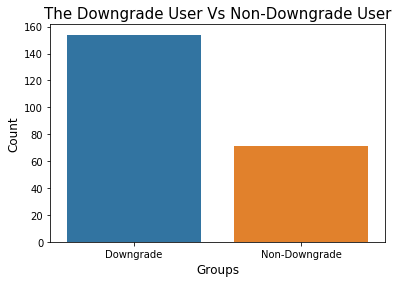

In [11]:
downgrade_pd = df.select('userId', 'Downgrade').dropDuplicates().groupBy('Downgrade').count().toPandas()
downgrade_pd.Downgrade = downgrade_pd.Downgrade.apply(lambda x: "Downgrade" if x==1 else "Non-Downgrade")
sns.barplot(x="Downgrade", y="count", data=downgrade_pd)
plt.title("The Downgrade User Vs Non-Downgrade User", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Count", fontsize=12);

In [12]:
downgrade_number = downgrade_pd.loc[downgrade_pd.Downgrade=="Downgrade", "count"][0]
non_downgrade_number = downgrade_pd.loc[downgrade_pd.Downgrade=="Non-Downgrade", "count"][1]
print(downgrade_number, non_downgrade_number)

154 71


##### Define year, month, day, hour , active_time for each user

In [13]:
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).year, IntegerType())
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).month, IntegerType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).day, IntegerType())
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour, IntegerType())

df = df.withColumn('year', get_year(df.ts))
df = df.withColumn('month', get_month(df.ts))
df = df.withColumn('day', get_day(df.ts))
df = df.withColumn('hour', get_hour(df.ts))

df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0, Downgrade=1, year=2018, month=10, day=1, hour=0)

In [14]:
df.describe(['hour', 'day', 'month', 'year']).show()

+-------+-----------------+------------------+------------------+------+
|summary|             hour|               day|             month|  year|
+-------+-----------------+------------------+------------------+------+
|  count|           278154|            278154|            278154|278154|
|   mean|12.20457372534639|15.793574782314833|10.479022412045126|2018.0|
| stddev|6.865469990132577| 8.926525825029135|0.4995894305896185|   0.0|
|    min|                0|                 1|                10|  2018|
|    max|               23|                31|                12|  2018|
+-------+-----------------+------------------+------------------+------+



观察到数据来源于2018年10月1日至12月31日

### 留存用户与流失用户组之间比较

##### 活跃时间比较

In [15]:
range_day = udf(lambda x: datetime.timedelta(0, x/1000.0).days, IntegerType())
df_time_range = df.select('userId', 'ts').groupBy('userId').agg(max(col('ts'))-min(col('ts')))
df_time_range = df_time_range.withColumn('range_day', range_day(df_time_range['(max(ts) - min(ts))']))
df_time_range = df_time_range.withColumn('Churn', churn(df_time_range.userId))
df_time_range.groupBy('Churn').agg(avg(col('range_day'))).show()

+-----+------------------+
|Churn|    avg(range_day)|
+-----+------------------+
|    1|23.134615384615383|
|    0| 46.52023121387283|
+-----+------------------+



用户平均活跃时间（天）：

In [16]:
avg_time = df_time_range.select('range_day').agg(avg('range_day')).collect()[0][0]
avg_time

41.11555555555555

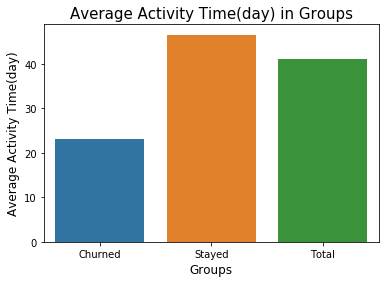

In [17]:
df_time_pd = df_time_range.groupBy('Churn').agg(avg(col('range_day'))).toPandas()
df_time_pd.Churn = df_time_pd.Churn.apply(lambda x: "Churned" if x==1 else "Stayed")
avg_time_pd = pd.DataFrame(data={"Churn": "Total", "avg(range_day)": avg_time}, index=[2])
df_time_pd = pd.concat([df_time_pd, avg_time_pd])
df_time_pd = df_time_pd.rename(columns={"Churn": "Groups", "avg(range_day)": "activity time(day)"})
sns.barplot(x="Groups", y="activity time(day)", data=df_time_pd)
plt.title("Average Activity Time(day) in Groups", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Average Activity Time(day)", fontsize=12);

观察发现留存用户组的平均活跃时间是流失用户组活跃时间的2倍左右

流失用户组与留存用户组平均活跃时间（天）：

In [18]:
avg_churn_time = df_time_pd.loc[df_time_pd.Groups=="Churned", "activity time(day)"][0]
avg_stay_time = df_time_pd.loc[df_time_pd.Groups=="Stayed", "activity time(day)"][1]
print(avg_churn_time, avg_stay_time)

23.1346153846 46.5202312139


要探索分析留存用户组与流失用户组之间的特征差异，要排除两组之间人数的差别以及平均活跃时间不同这两个因素。

因为后续使用机器学习方法的目的是预测用户流失的概率，以对流失概率高的用户采取一定的优惠措施。机器学习方法针对的是个体而不是总体，所以两组之间的样本数量差异会干扰机器学习方法的特征选取。在预测的时候某名用户在未来留存或流失是未知的，所以样本每名用户的活跃时间对机器学习方法没有参考价值

基于控制变量的考虑排除两组之间人数的差别以及平均活跃时间不同这两个因素可以更好地考察两组之间其他特征的差异（如播放音乐的数量）

**hour比较**

In [34]:
df_stay = df.filter(df.Churn==0)
df_churn = df.filter(df.Churn==1)

df_stay_pd = df_stay.groupBy('hour').count().orderBy(asc('hour')).toPandas()
df_stay_pd['count'] = df_stay_pd['count']/df_stay_pd['count'].sum()
df_stay_pd = df_stay_pd.rename(columns={'count': 'stay_group'})

df_churn_pd = df_churn.groupBy('hour').count().orderBy(asc('hour')).toPandas()
df_churn_pd['count'] = df_churn_pd['count']/df_churn_pd['count'].sum()
df_churn_pd = df_churn_pd.rename(columns={'count': 'churn_group'})

hour_pd = pd.concat([df_stay_pd, df_churn_pd.iloc[:,1]], axis=1)
hour_pd

,hour,stay_group,churn_group
0,0,0.039256,0.042818
1,1,0.036470,0.036577
2,2,0.036298,0.036265
3,3,0.036641,0.035173
4,4,0.036157,0.033858
5,5,0.036487,0.033368
6,6,0.035707,0.032788
7,7,0.035677,0.032944
8,8,0.036410,0.033568
9,9,0.037447,0.033011


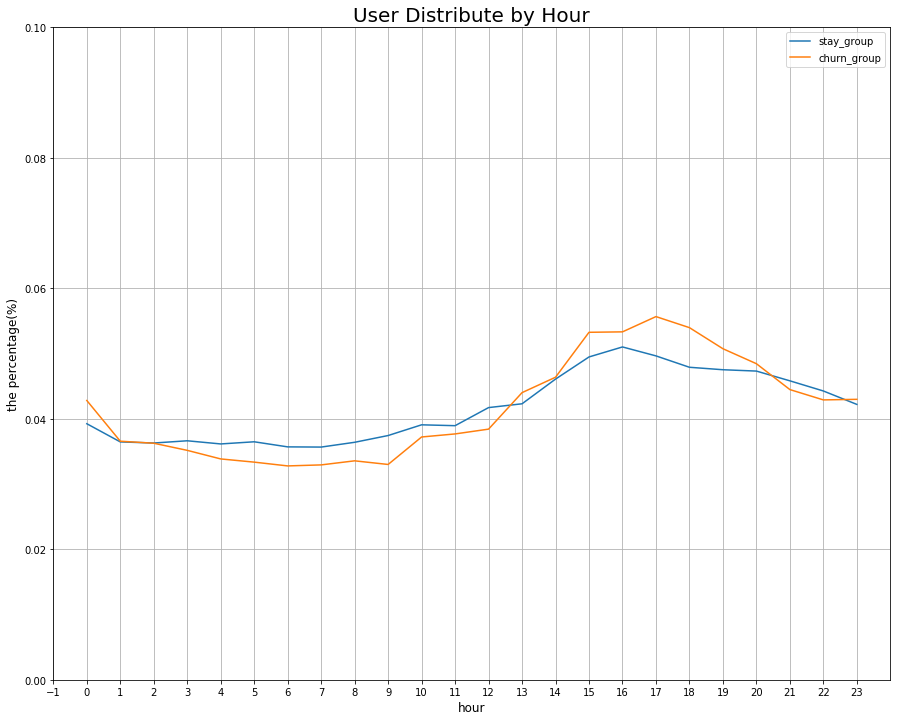

In [35]:
hour_pd.plot(x='hour', y=['stay_group', 'churn_group'], figsize=(15,12), 
             grid=True, legend=True, xlim=(-1, 24), ylim=(0, 0.1), xticks=np.arange(-1, 24, 1), fontsize=10)
plt.xlabel('hour', size=12)
plt.ylabel('the percentage(%)', size=12)
plt.title('User Distribute by Hour', size=20);

**month比较**

In [36]:
df_stay_pd = df_stay.groupBy('month').count().orderBy(asc('month')).toPandas()
df_stay_pd['count'] = df_stay_pd['count']/df_stay_pd['count'].sum()
df_stay_pd = df_stay_pd.rename(columns={'count': 'stay_group'})

df_churn_pd = df_churn.groupBy('month').count().orderBy(asc('month')).toPandas()
df_churn_pd['count'] = df_churn_pd['count']/df_churn_pd['count'].sum()
df_churn_pd = df_churn_pd.rename(columns={'count': 'churn_group'})

month_pd = pd.concat([df_stay_pd, df_churn_pd.iloc[:,1]], axis=1)
month_pd

,month,stay_group,churn_group
0,10,0.462442,0.82545
1,11,0.537541,0.17455
2,12,0.000017,NaN


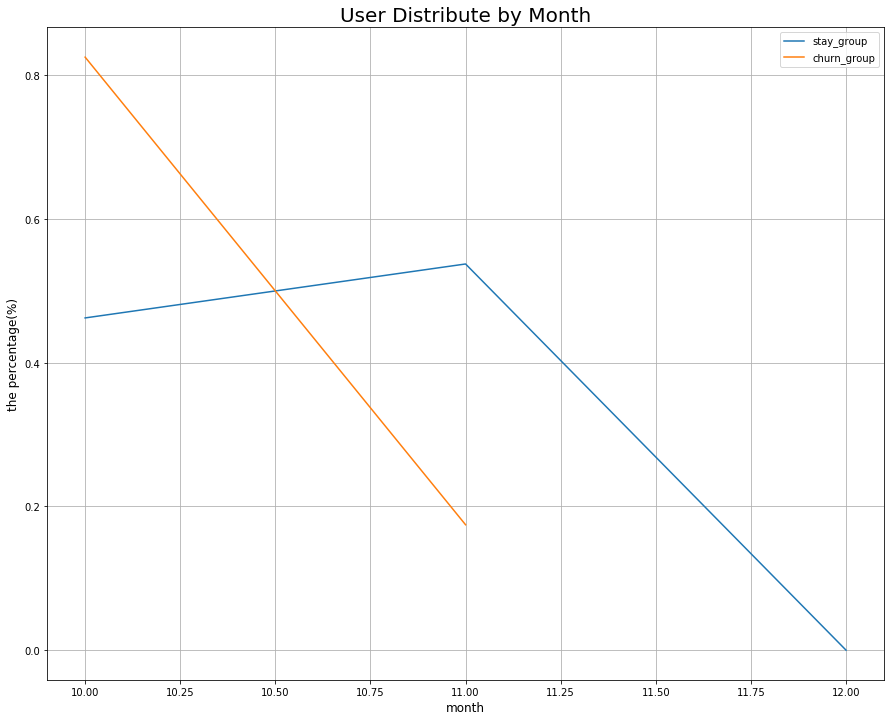

In [37]:
month_pd.plot(x='month', y=['stay_group', 'churn_group'], figsize=(15,12), 
             grid=True, legend=True, fontsize=10)
plt.xlabel('month', size=12)
plt.ylabel('the percentage(%)', size=12)
plt.title('User Distribute by Month', size=20);

流失用户大多数出现在10月

**level数量比较**

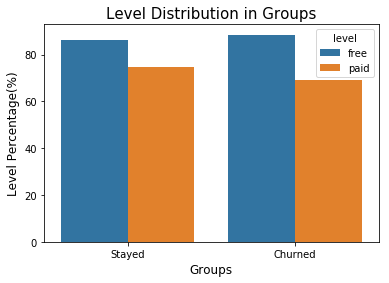

In [38]:
level_pd = df.select('userId', 'level', 'Churn').dropDuplicates().groupBy(['Churn', 'level']).count().toPandas()
level_pd["count"] = level_pd["count"].apply(lambda x: 100*x/churn_number \
                                            if x in np.array(level_pd.loc[level_pd.Churn==1, "count"]) \
                                            else 100*x/stay_number)
level_pd.Churn = level_pd.Churn.apply(lambda x: "Churned" if x==1 else "Stayed")
sns.barplot(x="Churn", y="count", hue="level", data=level_pd)
plt.title("Level Distribution in Groups", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Level Percentage(%)", fontsize=12);

可以发现流失用户组与留存用户组用户level分布大致相同

**Gender数量比较**

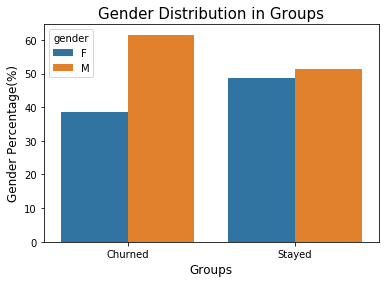

In [39]:
gender_pd = df.select('userId', 'gender', 'Churn').dropDuplicates().groupBy(['Churn', 'gender']).count().toPandas()
gender_pd["count"] = gender_pd["count"].apply(lambda x: 100*x/churn_number \
                                            if x in np.array(gender_pd.loc[gender_pd.Churn==1, "count"]) \
                                            else 100*x/stay_number)
gender_pd.Churn = gender_pd.Churn.apply(lambda x: "Churned" if x==1 else "Stayed")
sns.barplot(x="Churn", y="count", hue="gender", data=gender_pd)
plt.title("Gender Distribution in Groups", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Gender Percentage(%)", fontsize=12);

可以发现流失用户组与留存用户组相比男性占更大比例，性别可以作为预测用户流失或留存的特征之一

**播放音乐数量比较**

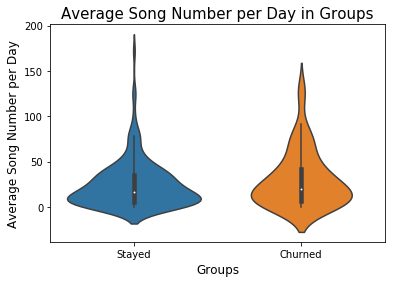

In [40]:
num_song_pd = df.filter(df.page=='NextSong').groupBy('userId', 'Churn').count().toPandas()
num_song_pd["count"] = num_song_pd["count"].apply(lambda x: x/avg_churn_time \
                                            if x in np.array(num_song_pd.loc[num_song_pd.Churn==1, "count"]) \
                                            else x/avg_stay_time)
num_song_pd.Churn = num_song_pd.Churn.apply(lambda x: "Churned" if x==1 else "Stayed")
num_song_pd = num_song_pd.rename(columns={"Churn": "Groups", "count": "Song_num_per_day"})
sns.violinplot(x="Groups", y="Song_num_per_day", data=num_song_pd)
plt.title("Average Song Number per Day in Groups", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Average Song Number per Day", fontsize=12);

可以发现留存用户组与流失用户组平均每天播放音乐数量存在差别，用户平均每天播放音乐数量可以作为预测用户流失或留存的特征之一

**Trumbs Down数量比较**

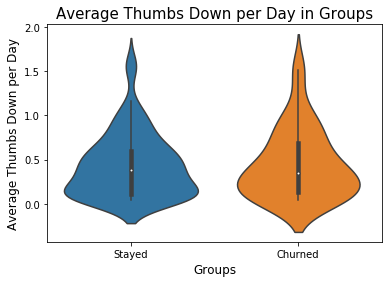

In [41]:
thumbs_down_pd = df.filter(df.page=='Thumbs Down').groupBy('userId', 'Churn').count().toPandas()
thumbs_down_pd["count"] = thumbs_down_pd["count"].apply(lambda x: x/avg_churn_time \
                                            if x in np.array(thumbs_down_pd.loc[thumbs_down_pd.Churn==1, "count"]) \
                                            else x/avg_stay_time)
thumbs_down_pd.Churn = thumbs_down_pd.Churn.apply(lambda x: "Churned" if x==1 else "Stayed")
thumbs_down_pd = thumbs_down_pd.rename(columns={"Churn": "Groups", "count": "Thumbs_down_per_day"})
sns.violinplot(x="Groups", y="Thumbs_down_per_day", data=thumbs_down_pd)
plt.title("Average Thumbs Down per Day in Groups", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Average Thumbs Down per Day", fontsize=12);

流失用户组与留存用户组平均每天Thumbs Down数量大致相等

**Trumbs Up数量比较**

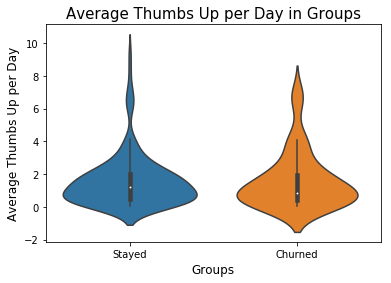

In [42]:
thumbs_up_pd = df.filter(df.page=='Thumbs Up').groupBy('userId', 'Churn').count().toPandas()
thumbs_up_pd["count"] = thumbs_up_pd["count"].apply(lambda x: x/avg_churn_time \
                                            if x in np.array(thumbs_up_pd.loc[thumbs_up_pd.Churn==1, "count"]) \
                                            else x/avg_stay_time)
thumbs_up_pd.Churn = thumbs_up_pd.Churn.apply(lambda x: "Churned" if x==1 else "Stayed")
thumbs_up_pd = thumbs_up_pd.rename(columns={"Churn": "Groups", "count": "Thumbs_up_per_day"})
sns.violinplot(x="Groups", y="Thumbs_up_per_day", data=thumbs_up_pd)
plt.title("Average Thumbs Up per Day in Groups", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Average Thumbs Up per Day", fontsize=12);

留存用户组比流失用户组平均每天Thumbs Up数量多，用户平均每天Thumbs Up数量可以作为预测用户流失或留存的特征之一

**Roll Advert数量比较**

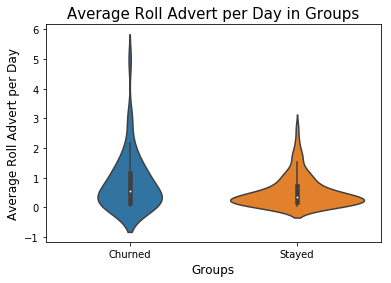

In [43]:
rovert_ad_pd = df.filter(df.page=='Roll Advert').groupBy('userId', 'Churn').count().toPandas()
rovert_ad_pd["count"] = rovert_ad_pd["count"].apply(lambda x: x/avg_churn_time \
                                            if x in np.array(rovert_ad_pd.loc[rovert_ad_pd.Churn==1, "count"]) \
                                            else x/avg_stay_time)
rovert_ad_pd.Churn = rovert_ad_pd.Churn.apply(lambda x: "Churned" if x==1 else "Stayed")
rovert_ad_pd = rovert_ad_pd.rename(columns={"Churn": "Groups", "count": "Roll_advert_per_day"})
sns.violinplot(x="Groups", y="Roll_advert_per_day", data=rovert_ad_pd)
plt.title("Average Roll Advert per Day in Groups", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Average Roll Advert per Day", fontsize=12);

可以发现流失用户组平均每天Roll Advert数量明显多于留存用户组。所以，用户每天平均Roll Advert的次数可以作为预测未来留存或流失的重要特征

**Submit Downgrade数量比较**

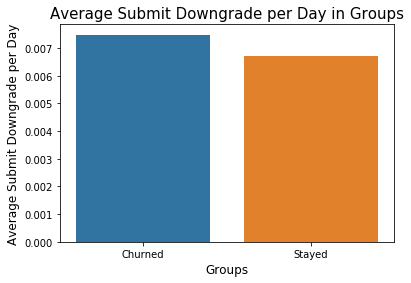

In [44]:
submit_downgrade_pd = df.filter(df.page=='Submit Downgrade').groupBy('Churn').count().toPandas()
submit_downgrade_pd["count"] = submit_downgrade_pd["count"].apply(lambda x: x/(churn_number*avg_churn_time) \
                                            if x in np.array(submit_downgrade_pd.loc[submit_downgrade_pd.Churn==1, "count"]) \
                                            else x/(stay_number*avg_stay_time))
submit_downgrade_pd.Churn = submit_downgrade_pd.Churn.apply(lambda x: "Churned" if x==1 else "Stayed")
submit_downgrade_pd = submit_downgrade_pd.rename(columns={"Churn": "Groups", "count": "Submit_downgrade_per_day"})
sns.barplot(x="Groups", y="Submit_downgrade_per_day", data=submit_downgrade_pd)
plt.title("Average Submit Downgrade per Day in Groups", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Average Submit Downgrade per Day", fontsize=12);

可以发现流失用户组与留存用户组平均每天Submit Downgrade数量大致相等

**Downgrade数量比较**

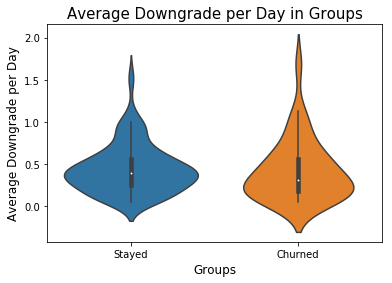

In [45]:
downgrade_pd = df.filter(df.page=='Downgrade').groupBy('userId', 'Churn').count().toPandas()
downgrade_pd["count"] = downgrade_pd["count"].apply(lambda x: x/avg_churn_time \
                                            if x in np.array(downgrade_pd.loc[downgrade_pd.Churn==1, "count"]) \
                                            else x/avg_stay_time)
downgrade_pd.Churn = downgrade_pd.Churn.apply(lambda x: "Churned" if x==1 else "Stayed")
downgrade_pd = downgrade_pd.rename(columns={"Churn": "Groups", "count": "Downgrade_per_day"})
sns.violinplot(x="Groups", y="Downgrade_per_day", data=downgrade_pd)
plt.title("Average Downgrade per Day in Groups", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Average Downgrade per Day", fontsize=12);

可以发现留存用户组与流失用户组平均每天Downgrade数量存在差别，用户平均每天Downgrade数量可以作为预测用户流失或留存的特征之一

**Add to Playlist数量比较**

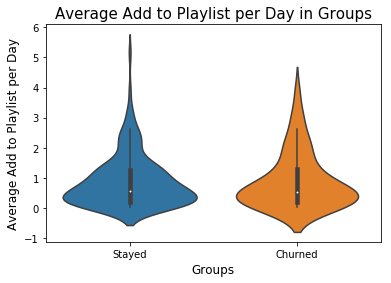

In [46]:
add_playlist_pd = df.filter(df.page=='Add to Playlist').groupBy('userId', 'Churn').count().toPandas()
add_playlist_pd["count"] = add_playlist_pd["count"].apply(lambda x: x/avg_churn_time \
                                            if x in np.array(add_playlist_pd.loc[add_playlist_pd.Churn==1, "count"]) \
                                            else x/avg_stay_time)
add_playlist_pd.Churn = add_playlist_pd.Churn.apply(lambda x: "Churned" if x==1 else "Stayed")
add_playlist_pd = add_playlist_pd.rename(columns={"Churn": "Groups", "count": "Add_playlist_per_day"})
sns.violinplot(x="Groups", y="Add_playlist_per_day", data=add_playlist_pd)
plt.title("Average Add to Playlist per Day in Groups", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Average Add to Playlist per Day", fontsize=12);

可以发现留存用户组与流失用户组平均每天Add to Playlist数量存在差别，用户平均每天Add to Playlist数量可以作为预测用户流失或留存的特征之一

**Add Friend数量比较**

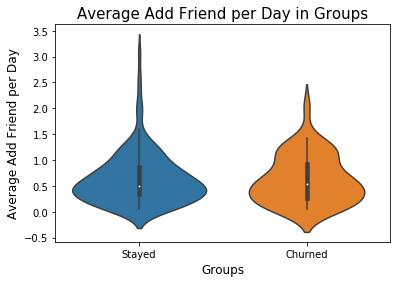

In [47]:
add_friend_pd = df.filter(df.page=='Add Friend').groupBy('userId', 'Churn').count().toPandas()
add_friend_pd["count"] = add_friend_pd["count"].apply(lambda x: x/avg_churn_time \
                                            if x in np.array(add_friend_pd.loc[add_friend_pd.Churn==1, "count"]) \
                                            else x/avg_stay_time)
add_friend_pd.Churn = add_friend_pd.Churn.apply(lambda x: "Churned" if x==1 else "Stayed")
add_friend_pd = add_friend_pd.rename(columns={"Churn": "Groups", "count": "Add_friend_per_day"})
sns.violinplot(x="Groups", y="Add_friend_per_day", data=add_friend_pd)
plt.title("Average Add Friend per Day in Groups", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Average Add Friend per Day", fontsize=12);

可以发现留存用户组与流失用户组平均每天Add Friend数量存在差别，用户平均每天Add Friend数量可以作为预测用户流失或留存的特征之一

**Help数量比较**

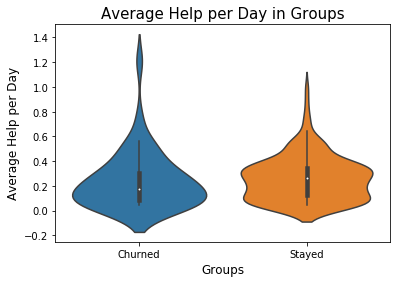

In [48]:
help_pd = df.filter(df.page=='Help').groupBy('userId', 'Churn').count().toPandas()
help_pd["count"] = help_pd["count"].apply(lambda x: x/avg_churn_time \
                                            if x in np.array(help_pd.loc[help_pd.Churn==1, "count"]) \
                                            else x/avg_stay_time)
help_pd.Churn = help_pd.Churn.apply(lambda x: "Churned" if x==1 else "Stayed")
help_pd = help_pd.rename(columns={"Churn": "Groups", "count": "Help_per_day"})
sns.violinplot(x="Groups", y="Help_per_day", data=help_pd)
plt.title("Average Help per Day in Groups", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Average Help per Day", fontsize=12);

可以发现留存用户组与流失用户组平均每天Help数量存在差别，用户平均每天Help数量可以作为预测用户流失或留存的特征之一

**Settings数量比较**

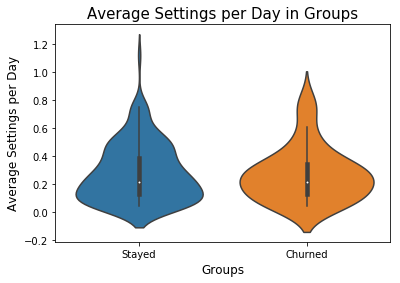

In [49]:
settings_pd = df.filter(df.page=='Settings').groupBy('userId', 'Churn').count().toPandas()
settings_pd["count"] = settings_pd["count"].apply(lambda x: x/avg_churn_time \
                                            if x in np.array(settings_pd.loc[settings_pd.Churn==1, "count"]) \
                                            else x/avg_stay_time)
settings_pd.Churn = settings_pd.Churn.apply(lambda x: "Churned" if x==1 else "Stayed")
settings_pd = settings_pd.rename(columns={"Churn": "Groups", "count": "Settings_per_day"})
sns.violinplot(x="Groups", y="Settings_per_day", data=settings_pd)
plt.title("Average Settings per Day in Groups", fontsize=15)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Average Settings per Day", fontsize=12);

可以发现留存用户组与流失用户组平均每天Settings数量存在差别，用户平均每天Settings数量可以作为预测用户流失或留存的特征之一

### 综上所述

**经过探索性分析，有以下特征可以用来预测未来用户留存或流失：**

1 用户每天平均Roll Advert的数量

2 性别

3 用户平均每天Help数量

4 用户平均每天Setings数量

5 用户平均每天Add Friend数量

6 用户平均每天Downgrade数量

7 用户平均每天Thumbs Up数量

8 用户每天平均播放音乐数量

9 用户平均每天Add to Playlist数量

按照流失用户组与留存用户组特征差异由大到小排序

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

In [19]:
range_second = udf(lambda x: datetime.timedelta(0, x/1000.0).seconds, IntegerType())
range_day = udf(lambda x: datetime.timedelta(0, x/1000.0).days, IntegerType())
df_feature = df.select('userId', 'ts', 'page', 'gender').groupBy('userId') \
            .agg(max(col('ts'))-min(col('ts')), count(col('page')), count(when(df.page=='Roll Advert', 1)), \
                count(when(df.page=='Thumbs Up', 1)), count(when(df.page=='Downgrade', 1)), \
                count(when(df.page=='NextSong', 1)), count(when(df.page=='Add to Playlist', 1)), \
                count(when(df.page=='Help', 1)), count(when(df.page=='Settings', 1)), \
                count(when(df.page=='Add Friend', 1)), min(df.gender))

df_feature = df_feature.withColumn('second', range_second(df_feature['(max(ts) - min(ts))']))
df_feature = df_feature.withColumn('day', range_day(df_feature['(max(ts) - min(ts))']))
df_feature = df_feature.withColumn('Churn', churn(df_feature.userId))
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = Roll Advert) THEN 1 END)', 'Roll Advert')
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = Thumbs Up) THEN 1 END)', 'Thumbs Up')
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = Downgrade) THEN 1 END)', 'Downgrade')
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = NextSong) THEN 1 END)', 'Song Number')
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = Add to Playlist) THEN 1 END)', 'Add to Playlist')
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = Help) THEN 1 END)', 'Help')
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = Settings) THEN 1 END)', 'Settings')
df_feature = df_feature.withColumnRenamed('count(CASE WHEN (page = Add Friend) THEN 1 END)', 'Add Friend')
df_feature = df_feature.withColumnRenamed('min(gender)', 'gender')
df_feature = df_feature.withColumn('time', df_feature.day+df_feature.second/(3600*24))
df_feature = df_feature.select('userId', 'gender', 'Roll Advert', 'Help', 'Settings', 'Add Friend', \
                               'Downgrade', 'Thumbs Up', 'Song Number', 'Add to Playlist', 'time', 'Churn')
df_feature.show()

+------+------+-----------+----+--------+----------+---------+---------+-----------+---------------+-------------------+-----+
|userId|gender|Roll Advert|Help|Settings|Add Friend|Downgrade|Thumbs Up|Song Number|Add to Playlist|               time|Churn|
+------+------+-----------+----+--------+----------+---------+---------+-----------+---------------+-------------------+-----+
|100010|     F|         52|   2|       0|         4|        0|       17|        275|              7|  44.21780092592593|    0|
|200002|     M|          7|   2|       3|         4|        5|       21|        387|              8| 45.496805555555554|    0|
|   125|     M|          1|   0|       0|         0|        0|        0|          8|              0|0.02053240740740741|    1|
|   124|     F|          4|  23|      20|        74|       41|      171|       4079|            118| 59.996944444444445|    0|
|    51|     M|          0|  12|      12|        28|       23|      100|       2111|             52| 15.7793981

In [20]:
df_feature = df_feature.withColumn('Roll Advert', df_feature['Roll Advert']/df_feature.time)
df_feature = df_feature.withColumn('Thumbs Up', df_feature['Thumbs Up']/df_feature.time)
df_feature = df_feature.withColumn('Downgrade', df_feature['Downgrade']/df_feature.time)
df_feature = df_feature.withColumn('Song Number', df_feature['Song Number']/df_feature.time)
df_feature = df_feature.withColumn('Add to Playlist', df_feature['Add to Playlist']/df_feature.time)
df_feature = df_feature.withColumn('Help', df_feature['Help']/df_feature.time)
df_feature = df_feature.withColumn('Settings', df_feature['Settings']/df_feature.time)
df_feature = df_feature.withColumn('Add Friend', df_feature['Add Friend']/df_feature.time)

df_feature.take(5)

[Row(userId='100010', gender='F', Roll Advert=1.1759969720590784, Help=0.04523065277150301, Settings=0.0, Add Friend=0.09046130554300602, Downgrade=0.0, Thumbs Up=0.3844605485577756, Song Number=6.219214756081664, Add to Playlist=0.15830728470026054, time=44.21780092592593, Churn=0),
 Row(userId='200002', gender='M', Roll Advert=0.15385695576917793, Help=0.04395913021976513, Settings=0.06593869532964769, Add Friend=0.08791826043953026, Downgrade=0.10989782554941281, Thumbs Up=0.4615708673075338, Song Number=8.506091697524552, Add to Playlist=0.17583652087906051, time=45.496805555555554, Churn=0),
 Row(userId='125', gender='M', Roll Advert=48.70349492671927, Help=0.0, Settings=0.0, Add Friend=0.0, Downgrade=0.0, Thumbs Up=0.0, Song Number=389.6279594137542, Add to Playlist=0.0, time=0.02053240740740741, Churn=1),
 Row(userId='124', gender='F', Roll Advert=0.06667006190130052, Help=0.38335285593247803, Settings=0.33335030950650263, Add Friend=1.2333961451740598, Downgrade=0.6833681344883

In [21]:
df_feature.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- Roll Advert: double (nullable = true)
 |-- Help: double (nullable = true)
 |-- Settings: double (nullable = true)
 |-- Add Friend: double (nullable = true)
 |-- Downgrade: double (nullable = true)
 |-- Thumbs Up: double (nullable = true)
 |-- Song Number: double (nullable = true)
 |-- Add to Playlist: double (nullable = true)
 |-- time: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [22]:
indexer1 = StringIndexer(inputCol='gender', outputCol='gender_')
vectorassembler1 = VectorAssembler(inputCols=df_feature.columns[2:-2], outputCol='features_')
scale = StandardScaler(inputCol='features_', outputCol='features__', withMean=True, withStd=True)
vectorassembler2 = VectorAssembler(inputCols=['gender_','features__'], outputCol='features')
indexer2 = StringIndexer(inputCol='Churn', outputCol='label')

pipeline = Pipeline(stages=[indexer1, vectorassembler1, scale, vectorassembler2, indexer2])

pModel = pipeline.fit(df_feature)
df_feature_ = pModel.transform(df_feature)
df_feature_ = df_feature_.select('userId', 'features', 'label')
df_feature_.take(5)

[Row(userId='100010', features=DenseVector([1.0, -0.1231, -0.2015, -0.1127, -0.1998, -0.4801, -0.3033, -0.4555, -0.2609]), label=0.0),
 Row(userId='200002', features=DenseVector([0.0, -0.1832, -0.2028, -0.1081, -0.2004, -0.2684, -0.2926, -0.4307, -0.2574]), label=0.0),
 Row(userId='125', features=DenseVector([0.0, 2.6718, -0.249, -0.1127, -0.2206, -0.4801, -0.3568, 3.7108, -0.2925]), label=1.0),
 Row(userId='124', features=DenseVector([1.0, -0.1883, 0.1535, -0.0894, 0.0633, 0.8365, 0.0395, 0.2157, 0.1005]), label=0.0),
 Row(userId='51', features=DenseVector([0.0, -0.1923, 0.5494, -0.0595, 0.1878, 2.3281, 0.5243, 0.9306, 0.366]), label=1.0)]

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [23]:
train, test = df_feature_.randomSplit([0.8, 0.2], seed=42)

**Basic Model**

1 预测所有用户全部留存

假设分类器判断所有用户都为留存用户

In [55]:
basic_result_0 = test.withColumn("predict", lit(0.0))

evaluator = MulticlassClassificationEvaluator(predictionCol='predict')
print("predict all user stayed: ")
print("Accuracy: {}".format(evaluator.evaluate(basic_result_0, {evaluator.metricName: "accuracy"})))
print("F1 Score: {}".format(evaluator.evaluate(basic_result_0, {evaluator.metricName: "f1"})))


predict all user stayed: 
Accuracy: 0.7647058823529411
F1 Score: 0.6627450980392157


假设分类器判断所有用户都为流失用户

In [56]:
basic_result_1 = test.withColumn("predict", lit(1.0))

evaluator = MulticlassClassificationEvaluator(predictionCol='predict')
print("predict all user churned: ")
print("Accuracy: {}".format(evaluator.evaluate(basic_result_1, {evaluator.metricName: "accuracy"})))
print("F1 Score: {}".format(evaluator.evaluate(basic_result_1, {evaluator.metricName: "f1"})))


predict all user churned: 
Accuracy: 0.23529411764705882
F1 Score: 0.0896358543417367


建模调参后的分类器的质量必须好于上述基础模型

**LogisticRegression:**

In [26]:
start = time.time()
lr = LogisticRegression(maxIter=50)
paraGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=lr, estimatorParamMaps=paraGrid, \
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"), numFolds=3)
lrModel = crossval.fit(train)
end = time.time()
print("Training Time : {}".format(end-start))
lrModel.avgMetrics

Training Time : 354.55540561676025


[0.7522275366712448]

In [27]:
results_lr = lrModel.bestModel.transform(test)
evaluator=MulticlassClassificationEvaluator()
print("Accuracy: {}".format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print("F1 Score: {}".format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Accuracy: 0.7941176470588235
F1 Score: 0.7262656475019387


**LinearSVC:**

In [28]:
start = time.time()
lsvc = LinearSVC(maxIter=10)
paraGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=lsvc, estimatorParamMaps=paraGrid, \
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"), numFolds=3)
lsvcModel = crossval.fit(train)
end = time.time()
print("Training Time : {}".format(end-start))
lsvcModel.avgMetrics

Training Time : 589.9088156223297


[0.6757330259205702]

In [29]:
results_lsvc = lsvcModel.bestModel.transform(test)
evaluator=MulticlassClassificationEvaluator()
print("Accuracy: {}".format(evaluator.evaluate(results_lsvc, {evaluator.metricName: "accuracy"})))
print("F1 Score: {}".format(evaluator.evaluate(results_lsvc, {evaluator.metricName: "f1"})))

Accuracy: 0.7647058823529411
F1 Score: 0.6627450980392157


LinearSVC的训练结果几乎与假设分类器判断所有用户都为留存用户的Basic Model一致，并没有表现得更好

**RandomForest:**

In [63]:
start = time.time()
rf = RandomForestClassifier(seed=42)
paraGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=rf, estimatorParamMaps=paraGrid, \
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"), numFolds=3)
rfModel = crossval.fit(train)
end = time.time()
print("Training Time : {}".format(end-start))
rfModel.avgMetrics

Training Time : 243.8307695388794


[0.730103036013706]

In [64]:
results_rf = rfModel.bestModel.transform(test)
evaluator=MulticlassClassificationEvaluator()
print("Accuracy: {}".format(evaluator.evaluate(results_rf, {evaluator.metricName: "accuracy"})))
print("F1 Score: {}".format(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})))

Accuracy: 0.7941176470588235
F1 Score: 0.7262656475019387


**GradientBoost:**

In [59]:
start = time.time()
gb = GBTClassifier(seed=42)
paraGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=gb, estimatorParamMaps=paraGrid, \
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"), numFolds=3)
gbModel = crossval.fit(train)
end = time.time()
print("Training Time : {}".format(end-start))
gbModel.avgMetrics

Training Time : 1057.0708003044128


[0.6992624501393876]

In [60]:
results_gb = gbModel.bestModel.transform(test)
evaluator=MulticlassClassificationEvaluator()
print("Accuracy: {}".format(evaluator.evaluate(results_gb, {evaluator.metricName: "accuracy"})))
print("F1 Score: {}".format(evaluator.evaluate(results_gb, {evaluator.metricName: "f1"})))

Accuracy: 0.7647058823529411
F1 Score: 0.706288032454361


### 对模型进行调参

综合考虑训练时间与F1 Score,以及模型的特性,选择LogisticRegression与RandomForest两种模型进行超参数调整。因为LinearSVC与LogisticRegression原理相似, 都取决于不同类别之间分界超平面附近的数据点,但LogisticRegression的训练时间明显少于LinearSVC。GradientBoost需要不断迭代，速度较慢,超参数调整需要耗费更多时间

**LogisticRegression:**

依次设定regularization parameter为0.0, 0.01, 0.1, 1.0, 10.0，分类器的robust不断增加

In [61]:
start = time.time()
lr = LogisticRegression(maxIter=50)
paraGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.01, 0.1, 1.0, 10.0]).build()
crossval = CrossValidator(estimator=lr, estimatorParamMaps=paraGrid, \
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"), numFolds=3)
lrModel = crossval.fit(train)
end = time.time()
print("Training Time : {}".format(end-start))
lrModel.avgMetrics

Training Time : 577.6444938182831


[0.7389608517757349,
 0.6731617213165118,
 0.6636408726452969,
 0.6692426331986138,
 0.6657029027921227]

In [62]:
results_lr = lrModel.bestModel.transform(test)
evaluator=MulticlassClassificationEvaluator()
print("Accuracy: {}".format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print("F1 Score: {}".format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))
lr_best_model = lrModel.bestModel
lr_best_model.save("best-logistic-model-1")
lr_best_model.extractParamMap()

Accuracy: 0.7941176470588235
F1 Score: 0.7262656475019387


{Param(parent='LogisticRegression_ae07ce204cf5', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_ae07ce204cf5', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_ae07ce204cf5', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_ae07ce204cf5', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_ae07ce204cf5', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_ae07ce204cf5', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_ae07ce204cf5', name='maxIter', doc='maximum number of iterations (>= 0)'): 

最佳的LogisticRegression模型regularization parameter为0.0,不使用正则化。最佳的LogisticRegression模型训练集的F1 Score为0.775,测试集的F1 Score为0.726,没有明显的过拟合。由于LogisticRegression模型只与分界的超平面附近的数据点有关,所以模型足够的稳健,模型进一步改善的余地也有限,因为LogisticRegression模型不能比不使用regularization更灵活了

**RandomForest:**

依次设定树的数量为10,20,30,40,50;树的深度为3,5,7。分类器随着树的数量增加而robust

In [59]:
start = time.time()
rf = RandomForestClassifier(seed=42)
paraGrid = ParamGridBuilder().addGrid(rf.numTrees, np.arange(10, 51, 10)) \
        .addGrid(rf.maxDepth, np.arange(3, 8, 2)).build()
crossval = CrossValidator(estimator=rf, estimatorParamMaps=paraGrid, \
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"), numFolds=3)
rfModel = crossval.fit(train)
end = time.time()
print("Training Time : {}".format(end-start))
rfModel.avgMetrics

Training Time : 1820.7164978981018


[0.7165917090160248,
 0.7349926265734603,
 0.7679253673194011,
 0.7273752909471476,
 0.730103036013706,
 0.7296801480542201,
 0.7180703432511221,
 0.7276778715873602,
 0.7688319963671143,
 0.7099275520897872,
 0.7612949452440778,
 0.734025907750902,
 0.7136174823984522,
 0.7196778633597953,
 0.7246464242107091]

In [60]:
results_rf = rfModel.bestModel.transform(test)
evaluator=MulticlassClassificationEvaluator()
print("Accuracy: {}".format(evaluator.evaluate(results_rf, {evaluator.metricName: "accuracy"})))
print("F1 Score: {}".format(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})))
rf_best_model = rfModel.bestModel
rf_best_model.save("best-random-forest-model-1")
rf_best_model.extractParamMap()

Accuracy: 0.7941176470588235
F1 Score: 0.7262656475019387


{Param(parent='RandomForestClassifier_1eb616697736', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_1eb616697736', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_1eb616697736', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_1eb616697736', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_1eb616697736', 

最佳的RandomForest模型树的数量为10，树的深度为7。最佳的RandomForest模型训练集的F1 Score为0.741，测试集的F1 Score为0.780，没有明显的过拟合。还可以继续增加树的深度以及减少树的数量来改善RandomForest模型的性能，提升其灵活性，但代价是模型的稳健性下降，更容易被干扰，也更容易过拟合。DecisionTree模型非常灵活，但极易过拟合，缺乏稳健性；RandomForest模型作为DecisionTree的集成方法，主要解决其稳健性差，容易过拟合的问题。

**Feature Importance:**

**Best Model:**

(训练多次发现，GridSearch有的时候不能得到最优参数组合，这里重新选择曾经得到的最优参数组合训练模型)

In [25]:
start = time.time()
rf_ = RandomForestClassifier(seed=42, numTrees=10, maxDepth=7)
paraGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=rf_, estimatorParamMaps=paraGrid, \
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"), numFolds=3)
rfModel_ = crossval.fit(train)
end = time.time()
print("Training Time : {}".format(end-start))
rfModel_.avgMetrics

Training Time : 277.36540722846985


[0.7229835711032783]

In [26]:
results_rf_ = rfModel_.bestModel.transform(test)
evaluator=MulticlassClassificationEvaluator()
print("Accuracy: {}".format(evaluator.evaluate(results_rf_, {evaluator.metricName: "accuracy"})))
print("F1 Score: {}".format(evaluator.evaluate(results_rf_, {evaluator.metricName: "f1"})))

Accuracy: 0.8235294117647058
F1 Score: 0.7797160243407708


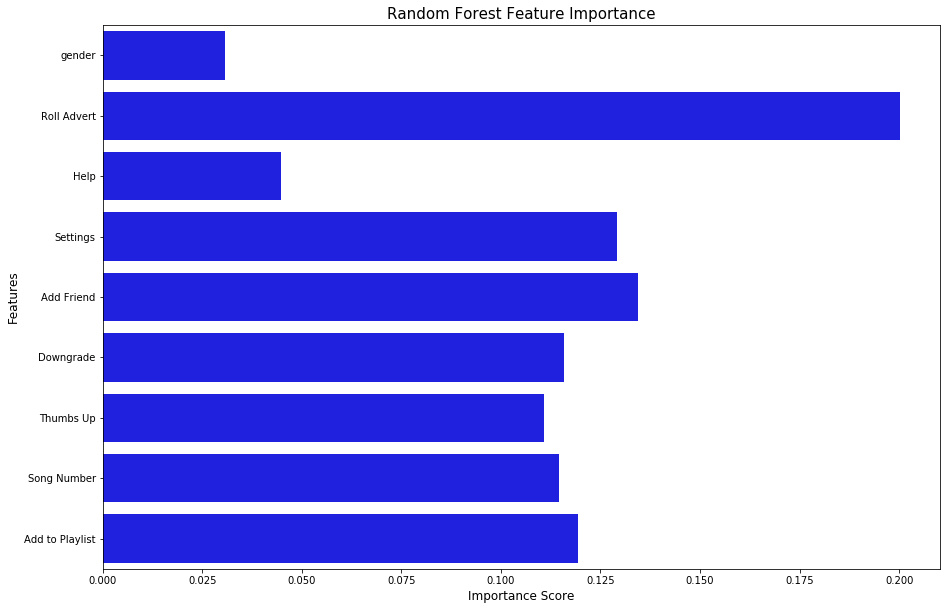

In [27]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
feature_importance = rfModel_.bestModel.featureImportances.values
labels = ["gender","Roll Advert","Help","Settings","Add Friend","Downgrade","Thumbs Up","Song Number","Add to Playlist"]
feature_importance_pd = pd.DataFrame(data=feature_importance, index=labels, columns=["feature_importance"])
sns.barplot(x="feature_importance", y=feature_importance_pd.index, data=feature_importance_pd, ax=ax, color="blue")
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Random Forest Feature Importance", fontsize=15);

使用了LogisticRegression,LinearSVC,RandomForest,GradientBoosting 四种分类器，对其进行交叉验证以及网格参数选取，比较发现RandomForest的f1-score分数最高，达到了0.780。这里选择f1-score作为评估指标，因为数据集中的标签分布不均匀，项目中重点关注的Churn用户占少数，所以综合考虑precission/recall的f1-score评估指标更为合适

# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。